# Table of Contents
 <p><div class="lev2"><a href="#Description-of-CROP"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Description of CROP</a></div><div class="lev1"><a href="#Objective-Function"><span class="toc-item-num">1&nbsp;&nbsp;</span>Objective Function</a></div><div class="lev2"><a href="#Probability-of-biochemical-feasibility"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Probability of biochemical feasibility</a></div><div class="lev2"><a href="#Probability-of-thermodynamic-feasibility"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Probability of thermodynamic feasibility</a></div><div class="lev2"><a href="#Maximum-a-posteriori-(MAP)-estimation"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Maximum <em>a posteriori</em> (MAP) estimation</a></div><div class="lev1"><a href="#Resolving-incorrect-predictions-by-restoring-growth"><span class="toc-item-num">2&nbsp;&nbsp;</span>Resolving incorrect predictions by restoring growth</a></div><div class="lev1"><a href="#Resolving-incorrect-predictions-by-suppressing-growth"><span class="toc-item-num">3&nbsp;&nbsp;</span>Resolving incorrect predictions by suppressing growth</a></div><div class="lev2"><a href="#Generic-solution-strategy"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Generic solution strategy</a></div><div class="lev3"><a href="#Resolving-the-nonlinearity-in-the-general-solution-strategy"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Resolving the nonlinearity in the general solution strategy</a></div><div class="lev2"><a href="#GrowMatch"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>GrowMatch</a></div><div class="lev2"><a href="#ModelSEED"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>ModelSEED</a></div><div class="lev2"><a href="#CROP"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CROP</a></div><div class="lev3"><a href="#ABC-model"><span class="toc-item-num">3.4.1&nbsp;&nbsp;</span>ABC model</a></div><div class="lev3"><a href="#Robustness"><span class="toc-item-num">3.4.2&nbsp;&nbsp;</span>Robustness</a></div><div class="lev4"><a href="#LP-dung-FBA-implementation"><span class="toc-item-num">3.4.2.1&nbsp;&nbsp;</span>LP dung-FBA implementation</a></div><div class="lev4"><a href="#Dual-of-LP-dung-FBA-Implementation"><span class="toc-item-num">3.4.2.2&nbsp;&nbsp;</span>Dual of LP dung-FBA Implementation</a></div><div class="lev4"><a href="#MILP-dung-FBA-Implementation"><span class="toc-item-num">3.4.2.3&nbsp;&nbsp;</span>MILP dung-FBA Implementation</a></div><div class="lev4"><a href="#Dual-of-MILP-dung-FBA--Implementation"><span class="toc-item-num">3.4.2.4&nbsp;&nbsp;</span>Dual of MILP dung-FBA  Implementation</a></div><div class="lev3"><a href="#Size"><span class="toc-item-num">3.4.3&nbsp;&nbsp;</span>Size</a></div><div class="lev4"><a href="#Reduced-bi-level-MILP-dung-FBA-implementation"><span class="toc-item-num">3.4.3.1&nbsp;&nbsp;</span>Reduced bi-level MILP dung-FBA implementation</a></div><div class="lev4"><a href="#Partially-reduced-bi-level-MILP-dung-FBA-implementation"><span class="toc-item-num">3.4.3.2&nbsp;&nbsp;</span>Partially reduced bi-level MILP dung-FBA implementation</a></div><div class="lev4"><a href="#Biomass-substituted-partially-reduced-bi-level-MILP-dung-FBA-implementation"><span class="toc-item-num">3.4.3.3&nbsp;&nbsp;</span>Biomass-substituted partially reduced bi-level MILP dung-FBA implementation</a></div><div class="lev3"><a href="#Handling-multiple-conditions-simultaneously"><span class="toc-item-num">3.4.4&nbsp;&nbsp;</span>Handling multiple conditions simultaneously</a></div><div class="lev4"><a href="#Multiple-condition-biomass-substituted-partially-reduced-bi-level-MILP-dung-FBA-Implementation"><span class="toc-item-num">3.4.4.1&nbsp;&nbsp;</span>Multiple condition biomass-substituted partially reduced bi-level MILP dung-FBA Implementation</a></div><div class="lev4"><a href="#Multiple-condition-nutrient-limited-partially-reduced-bi-level-MILP-dung-FBA-Implementation"><span class="toc-item-num">3.4.4.2&nbsp;&nbsp;</span>Multiple condition nutrient-limited partially reduced bi-level MILP dung-FBA Implementation</a></div><div class="lev1"><a href="#References"><span class="toc-item-num">4&nbsp;&nbsp;</span>References</a></div>

## Description of CROP ##

Here, we describe the [Consistent Reproduction Of growth/no-growth Phenotype (CROP)](http://journals.plos.org/ploscompbiol/article/file?type=supplementary&id=info:doi/10.1371/journal.pcbi.1003126.s011) algorithm of FARM. This optimization-based algorithm reconciles experimentally observed growth phenotypes with computationally predicted growth phenotypes by suggesting reaction additions/deletions to the metabolic network.
Our exposition is split into three sections.

* We describe the novel objective function that CROP uses to incorporate diverse evidence. 

We then describe our complete solution in the two situations where CROP is needed: 
* when no-growth is computationally predicted, but growth is experimentally observed; and 
* when growth is computationally predicted, but no-growth is experimentally observed.

In the last section, we also provide a reference implementation that can be executed within this notebook for each variation of the CROP algorithm .



# Objective Function #

CROP maximizes an objective function that has weights associated with each reaction. These reactions are represented as being irreversible, where reversible reactions are split into two irreversible reactions, so that CROP can also choose among the reaction directions. 

We derive the weights using maximum *a posteriori* (MAP) estimation. This estimation requires the probabilities that a reaction is biochemically and thermodynamically feasible, because CROP’s purpose is to identify a stoichiometric matrix that defines the feasible space of reaction fluxes.

## Probability of biochemical feasibility##

A reaction is biochemically feasible if the net flux is positive in the direction of the reaction. Spontaneous reactions are always biochemically feasible. Transport reactions that require a transporter are biochemically feasible if and only if the genome encodes the transport function. Non-spontaneous enzyme-catalyzed reactions are biochemically feasible if and only if the genome encodes the enzyme function. The probability that a non-spontaneous reaction is biochemically feasible depends on the probability that the genome encodes the required function.
Transport reactions were assigned a probability of one if they had associated evidence in NeurosporaCyc; otherwise they were assigned a probability of zero. Non-spontaneous enzyme-catalyzed reactions were assigned a probability from the enzyme function predictor EFICAz [[1]](http://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-10-107). When there was additional evidence available in NeurosporaCyc, such as genome annotation, pathway prediction, and experimental evidence from the literature, this evidence was used to update the assigned probabilities.

## Probability of thermodynamic feasibility ##

A reaction (in a given direction) is thermodynamically feasible if and only if its Gibbs free energy $\Delta G' < 0$. $\Delta G'$  is a function of the Gibbs free energy at standard state $\Delta G^0$ and of the substrate/product concentrations. This function is $\Delta G'=\Delta G^0 + RT\ln(Q)$, where $R$ is the gas constant, $T$ is the temperature in degrees Kelvin, and $Q$ is the mass-action ratio. For a biochemical equation of the form $aA + bB \rightarrow cC + dD$, we have:

$$\begin{eqnarray}
    \Delta G' & = & \Delta G^0+RT\ln\left (\frac{[C]^c[D]^d}{[A]^a[B]^b}\right)
\end{eqnarray}$$
    
We can estimate $\Delta G'$  from estimates of $\Delta G^0$ [[2]](https://www.ncbi.nlm.nih.gov/pubmed/18645197) and from physiological ranges of metabolite concentrations. We can further assess the variance of $\Delta G'$  from the variance of $\Delta G^0$. Taken together, we can use the approach of Fleming et al. [[3]](https://www.ncbi.nlm.nih.gov/pubmed/19783351) to estimate the probability that a given reaction direction is thermodynamically feasible.
Yet, when using this approach, we found that thermodynamically infeasible reactions were not sufficiently penalized, so we developed a novel way to estimate the probability that a given reaction direction is thermodynamically feasible. The reason that thermodynamically infeasible reactions were not sufficiently penalized was because metabolite concentrations were allowed to freely vary within the physiological range. We could not address this problem directly, because we do not have comprehensive measurements of metabolite concentrations across conditions. We do not even have comprehensive measurements of concentrations of cofactors, such as ATP, across conditions. This situation applies to all organisms, not only Neurospora [[4]](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002166). 
However, metabolite concentrations enter into equation (1) as ratios, not as absolutes. And these ratios -- such as $\frac{NAD^+}{NADH}$, $\frac{NADP^+}{NADPH}$, and $\frac{ATP}{ADP}$ -- are bounded above and below by thermodynamics [[5]](https://www.ncbi.nlm.nih.gov/pubmed/16299075). Thus, we used known bounds on the ratios of currency metabolites to bring our thermodynamic probability estimates more in line with known thermodynamic feasibility. To illustrate, consider the reaction:

$$glyoxylate + NADPH + H+ \rightarrow glycolate + NADP+$$

with $\Delta G^0$  estimate $-7.68 \frac{kcal}{mol}$. We have: 
 
$$\Delta G' = -7.68 + RT\ln\left(\frac{[glyoxylate][NADPH][H^+]}{[glycolate][NADP^+]}\right)$$

The maximum thermodynamic ratio of $\frac{[NADP^+]}{[NADPH]}$ has been estimated to be 1.1 [[2]](https://www.ncbi.nlm.nih.gov/pubmed/18645197), and it is thought that organisms try to maintain this ratio near its maximum. Thus, we assumed that in the cytosol $\frac{[NADP+]}{[NADPH]}=1.1$. To estimate $\Delta G'$,  we also assumed a neutral pH (i.e. $[H^+]=10^{-7}$).

$$\begin{array}{rcl}
\Delta G' & = & -7.68 + RT\ln\left(\frac{10^{-7}[glyoxylate]}{1.1[glycolate]}\right) \\
& = & -7.68 + 16RT\ln\left(\frac{[glyoxylate]}{[glycolate]}\right)\\
\end{array}$$
 
Now, we can use the physiological range of metabolite concentrations to constrain $[glyoxylate]$ and $[glycolate]$. But since we’ve already used the maximum thermodynamic ratio of $\frac{[NADP^+]}{[NADPH]}$, our confidence interval for   is much tighter, so the probability estimate is much more reliable. To our knowledge, using thermodynamic bounds on metabolite concentration ratios to obtain more accurate probabilistic estimates of thermodynamic feasibility is novel.



## Maximum *a posteriori* (MAP) estimation ##
Our derivation of weights associated with each reaction is motivated by MAP estimation. The reactions are irreversible reactions from a metabolic database, such as MetaCyc. We begin by defining a binary variable $Z_i$ for each reaction $i$ that denotes whether it is physiologically feasible for Neurospora to carry flux through reaction $i$ in a condition:

$$ Z_i = 
\begin{array}{cl}
1 & \text{reaction $i$ is physiologically feasible} \\
0 & \text{otherwise} \\
\end{array}\\ .$$

$Z=1$ corresponds to the event that reaction $i$ belongs in the "true" metabolic network. Thus, CROP’s purpose is to decide which $Z_i$’s should be one and which should be zero; this decision specifies the metabolic network.
We relate our data on probabilities of biochemical and thermodynamic feasibility (described above) to probabilities of physiological feasibility. 

$$\begin{array}{rcl}
p_i & = & P(\text{reaction $i$ is physiologically feasible}) \\
& = & P(\text{reaction $i$ is biochemically and thermodynamically feasible}) \\
& = & P(\text{reaction $i$ is biochemically feasible})P(\text{reaction $i$ is thermodynamically feasible})
\end{array}$$

We then use our data $p_i$ to formulate the MAP estimate for the vector of $Z_i$’s. This vector estimate is denoted by  $\hat{Z}$. 
$$\begin{eqnarray}
\hat{Z} & = & \underset{Z_i}{\text{argmax}}\prod_i P(Z_i|p_i) \\ 
& = & \underset{Z_i}{\text{argmax}}\sum_i \ln\left[P(Z_i|p_i)\right]  \\
\end{eqnarray}$$

The last equality holds true because the logarithm is a monotonically increasing function, so the vector of $Z_i$'s that maximize $P(Z_i|p_i)$ also maximize $\ln\left[P(Z_i|p_i)\right]$.
By definition of $p_i$, we know that:

$$\begin{equation}P(Z_i=1\ |\ p_i) = p_i\end{equation}$$
and similarly,
$$\begin{equation}P(Z_i=0\ |\ p_i) = 1-p_i\end{equation}$$

Now, we represent  $P(Z_i | p_i)$ as a mixture model, which “mixes” the cases where $Z_i=1$ and $Z_i=0$:
$$\begin{equation}
\begin{array}{rcl}
P(Z_i|p_i) & = & Z_iP(Z_i=1\ |p_i)+(1-Z_i)P(Z_i=0\ |p_i) \\
& = & Z_ip_i + (1-Z_i)(1-p_i)\\
\end{array}\end{equation}$$

We log-transform $(6)$ to obtain a form that matches $(3)$.

$$\begin{equation}\ln\left[P(Z_i|p_i)\right] = \ln\left[Z_ip_i + (1-Z_i)(1-p_i)\right]\end{equation}$$

We would like to optimize  equation $(7)$, as shown in equation $(3)$, subject to the constraints of the network. (The full optimization is discussed in the sections below.) Because the $Z_i$ variables are binary, this optimization problem is very computationally demanding – in fact, it is NP-hard. So that this already demanding optimization problem is tractable using available solvers, its objective function must be linear or quadratic, and for speed, it is desirable for it to be linear.
So we sought a linear approximation to equation $(11)$. To model this logarithmic function as a linear one, we appeal to the logarithm’s first-order Taylor series approximation around 0: $\ln(1+x)≈x$ for $-1<x\leq 1$. The appeal is implemented as:

$$\begin{equation}\begin{array}{rcl}
\ln\left[Z_ip_i+(1-Z_i)(1-p_i)\right] 
& = & \ln\left[Z_ip_i + (1 - Z_i-p_i + Z_ip_i)\right] \\
& = & \ln\left[ 1 + ( 2Z_ip_i - Z_i-p_i)\right] \\
& = & 2Z_ip_i -Z_i -p_i \\
\end{array}\end{equation}$$

To exclude the possibility that $Z_ip_i+(1-Z_i)(1-p_i)=0$, which would pose a problem for the logarithm,
we only need to assume that $0<p_i<1$.

We now put the above steps together to show our linear approximation for the MAP estimate
$$\begin{equation}\begin{array}{rcl}
\hat{Z} & = & \underset{Z}{\text{argmax}}\sum_i\ln\left[P(Z_i|p_i)\right] \\
& \approx & \underset{Z}{\text{argmax}}\sum_i2Z_ip_i-Z_i - p_i \\
& = & \underset{Z}{\text{argmax}}\sum_i2Z_ip_i-Z_i \\
& = & \underset{Z}{\text{argmax}}\sum_iZ_i(2p_i-1) \\
\end{array}\end{equation}$$

where terms without $Z_i$ were removed because they are not involved in the optimization. We simplify by multiplying through by $\frac{1}{2}$,
$$\hat{Z}  \approx \underset{Z}{\text{argmax}}\sum_iZ_i(p_i-0.5)$$

which can be stated in matrix notation as:
$$\begin{equation}\hat{Z} \approx \underset{Z}{\text{argmax }} Z(p-0.5)\end{equation}$$
This implies that our objective function is: $Z(p-0.5)$.

# Resolving incorrect predictions by restoring growth #
In this section, we mathematically deal with conditions where no-growth is predicted, but growth is experimentally observed. (A condition is defined by what genes are knocked-out and what nutrients are available.) The goal here is to identify model changes that restore growth in a given condition.
There are several model changes that can restore growth. One model change that can restore growth is to assign an isozyme to the reaction that is catalyzed by the knocked-out gene, so that the gene knockout does not lead to reaction removals. This change is implemented by modifying the gene-protein-reaction (GPR) associations. Another model change that can restore growth is to reduce the number of essential compounds required for growth. This is implemented by changing the biomass composition in the stoichiometric matrix. If neither of these model changes are appropriate, we can restore growth by adding reactions that are not in the model from a universal pathway database such as MetaCyc. To identify the reactions to add to the model to restore growth, we implemented a mixed-integer linear program (MILP). Consider a stoichiometric matrix $S$ with irreversible reactions from a universal pathway database that includes reactions from the model, a vector of binary variables $z$ with associated non-negative weights corresponding to reactions in the database, and a vector of reaction upper bounds  $U$. For example, if the condition limits the glucose uptake reaction to $10 \frac{mmol}{g\cdot Dry\ weight\cdot hour}$, then we set $U_{glucose}=10$, and for all other reactions we set $U=1000$, as a loose upper bound. If the condition includes a gene knockout, then for reactions $KO$ that require the gene, we set $U_{KO}=0$. Now, assume that the ATP flux must be at least `atp_maintenance`, and that growth, represented by $v_{biomass}$, must be at least `minimal_growth`. Then, the general form of the MILP is:

$$ \begin{equation}\begin{array}{lll}
\underset{z}{\min} & weights^Tz  & \\
\text{subject to:} & Sv = 0 & \\
& 0 \leq v_i\leq U_i &  \text{for $i\in$ model} \\
& 0\leq v_i\leq U_i\cdot z_i & \text{for $i\in$ database} \\
& v_{biomass} \geq \text{minimal growth} & \\
& v_{ATP} \geq \text{atp maintenance}  & \\
& z\in\{0,1\} & \\
\end{array}\end{equation}$$

The main difference between MILPs is how they assign weights for reactions from the database. GrowMatch [[6]](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000308) treats all reactions as having the same weight, so it minimizes the total number of reactions to add. The Model SEED [[7](https://www.ncbi.nlm.nih.gov/pubmed/19555510),[8](http://www.nature.com/nbt/journal/v28/n9/full/nbt.1672.html)] assigns these weights based on diverse evidence. Since there is one binary variable per reaction in the database, these MILPs can be very large, so they are time-consuming to solve.

Our formulation is similar to program $(11)$. Since program $(11)$ is a minimization, the weights in our objective function (derived in the previous section) should be $0.5-p$.  However, this means that if the probability of a reaction is greater than $50\%$, the solution set will include that reaction, even if it is not strictly required for growth. To ensure that unnecessary reactions are not added to the model, we require that our weights be non-negative. So, we slightly modify our objective function, and instead use: $weights=1-p$ , where $0<p<1$. 

Rather than solve the full MILP, we can first solve a linear relaxation of the MILP. This linear relaxation allows all of the variables $z_i$, which were formerly restricted to be binary, to lie anywhere between 0 and 1, inclusive.  

The idea behind this linear relaxation is that it minimizes a weighted sum of flux through the database reactions. Thus, reactions not assigned flux in the relaxation are not needed to restore growth; conversely, reactions assigned flux are likely to have a low weight and contribute to restoring growth. Then, the set of reactions whose $z_i>0$ in the linear relaxation becomes the set of reactions to add to the model, and these reactions restore growth. 
The set of reactions returned by the relaxation--termed the *relaxation set*-- is not necessarily optimal for $(11)$. However, we found this set of reactions to be very similar to the optimal set in practice, and furthermore we could efficiently improve the set in two ways. 

1. We can treat the *relaxation set* as if it were the set of all database reactions, and then optimize program $(11)$ normally. Because the relaxation set is much smaller than the set of all database reactions, this optimization runs remarkably quickly. 
2. We can solve program $(11)$ using the *relaxation set* as a high-quality feasible starting point (often called a warm-start), which can save the optimizer substantial computational time [[9]](http://link.springer.com/article/10.1023/A:1011416130639).


# Resolving incorrect predictions by suppressing growth #
In this section, we mathematically deal with conditions where growth is predicted, but no growth is experimentally observed. The goal here is to identify model changes that suppress *in silico* growth in a given condition. Importantly, these model changes should not have the side-effect of suppressing growth in other conditions where growth is experimentally observed, such as the condition of wild-type in minimal medium.
There are several model changes that can suppress growth. These are basically the reverse of those that restore growth. If the knocked-out gene encodes an isozyme, then removing its isozyme, or requiring both gene products as subunits of an enzyme complex, will lead to reaction removal. Reaction removal can suppress growth if the reaction is essential. Another model change that can suppress growth is to add metabolites to the biomass composition, since this increases the requirements for growth. These two model changes can also be implemented together. However, if neither of these model changes are appropriate, we can suppress growth by removing reactions from the model. To identify the reactions to remove from the model to suppress growth, we implemented an optimization. 
To illustrate the principles involved in the optimization, we first provide a generic optimization-based solution strategy. We then compare the generic strategy to the optimizations of GrowMatch [[6]](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000308) and Model SEED [[7](https://www.ncbi.nlm.nih.gov/pubmed/19555510),[8](http://www.nature.com/nbt/journal/v28/n9/full/nbt.1672.html)]. GrowMatch, Model SEED, and CROP all solve this problem using a large mixed integer linear program (MILP). 
All of these MILPs involve the dual linear program to FBA because  the dual characterized by the constraint that growth is not feasible. If these programs tried instead to simply set the FBA growth flux to zero, these programs would only represent that no-growth was feasible; they would not represent that growth is infeasible.

## Generic solution strategy ##

This strategy independently examines each condition where growth is predicted, but no growth is experimentally observed. For each such condition, a bi-level MILP is created. The purpose of this MILP is to find the optimal set of reactions to remove such that *in silico* growth becomes infeasible in this condition, but remains feasible for a set of control conditions, such as wild-type in minimal medium.
This MILP has the same variables as described previously: $S, U, z,$ `weights`, `minimal_growth`, and `atp_maintenance`. However, there are now two conditions: the condition where no growth is experimentally observed, and wild-type in minimal medium. Then, the vector $v$ represents flux for the condition where no growth is experimentally observed, and has upper bounds $U_{no-growth}$; the vector $w$ represents flux for wild-type in minimal medium, and has upper bounds $U_{wt}$.

$$\begin{equation}\begin{array}{ll}
\min_z  & weights^T(1-z)   \\
& 
 \begin{array}{llll}
  \max_v  & v_{biomass} \\
 & Sv=0  &  \text{ (inner problem}) \\
 &  0\leq v_i \leq U_{no growth,i}\cdot z_i  \\
\end{array} \\
& v_{biomass} \leq  \text{minimal growth}  \\
& Sw = 0   \\
& 0 \leq w_i \leq  U_{wt,i}\cdot z_i  \\
& w_{ATP} \geq \text{atp maintenance} \\
& z\in \{0,1\}  \\
\end{array}\end{equation}$$

The outer minimization problem represents the modeler's optimization to find the optimal set of reactions to remove such that *in silico* growth, represented by $v_{biomass}$, falls below `minimal_growth`. The constraint $v_{biomass}\leq$ `minimal_growth` implies that when there are no solutions that reduce growth to `minimal_growth`, the MILP will not report on solutions that partially reduce growth. However, such solutions may be helpful in cases where no complete solutions can be identified. 
The inner maximization problem of the program represents FBA, although without the requirement for ATP. We removed this requirement, because it may not be satisfied in the no-growth condition.
The Program is a bi-level MILP. To transform it into a single-level MILP, the inner maximization problem must be transformed into a set of constraints. This has been done using an ingenious technique proposed by Maranas’ lab [[10]](https://www.ncbi.nlm.nih.gov/pubmed/12673766) based on the strong duality theorem of linear programming. In this technique, the inner problem is transformed into a set of constraints by including the constraints of the inner problem’s dual, and then constraining the objectives of the inner problem and the inner problem’s dual to be equal.
Before illustrating the primal and dual formulations when $z$ is included, we first show this without $z$ for simplicity. Without $z$, the primal is FBA. To represent FBA in a way that will simplify the derivation of its dual, we represent FBA without unnecessary bounds. So if there is only a single limiting nutrient, e.g. $v_{glucose}\leq 10$, then we represent FBA with no other upper bounds. Moreover, $v_{glucose}$ does not need an explicit lower bound of zero, because it will never be negative. As with the inner problem above, we also remove the ATP maintenance requirement. Then, the form of the primal LP is:

$$\begin{array}{lll}
\max_v &c^Tv=v_{biomass} \\
\text{subject to } &Sv = 0 \\
& 0\leq v_i, &\text{ for $i\neq$ glucose} \\
&v_{glucose} \leq 10
\end{array}$$

Now, we need the dual. The reason we need the dual is because we want to model an upper bound on growth. To derive the dual, we follow the approach in [[11]](https://stanford.edu/~boyd/cvxbook/), which uses the  Lagrangian $L$:

$$\begin{array}{rcl}
L& = &c^Tv+ mSv - \sum_{i\neq glucose} r_i\cdot v_i+r_{glucose}\cdot(10 - v_{glucose}) \\
& = & 10r_{glucose} + (c + S^Tm - r)v \\
\end{array}$$

Then, the Lagrangian dual problem is:
$$\begin{array}{lll}
\min_{m,r}&\max_v & 10\cdot r_{glucose} + (c + S^Tm - r)v \\
& \text{subject to}& r_{glucose} \geq 0 \\
& & r_i \leq 0  \text{   for $i\neq$ glucose} \\
\end{array}$$

which is equivalent to:

$$\begin{equation}\begin{array}{lll}
\min_{m,r}& 10\cdot r_{glucose}  \\
\text{subject to}& S^Tm+c=r \\
& r_{glucose} \geq 0 \\
&r_i \leq 0 & \text{for $i\neq$ glucose} \\
\end{array}\end{equation}$$

Where $S^T$ is the transpose of the stochiometric matrix $S$, $r$ is the dual variable associated with reaction bounds (e.g. $v\geq 0$ and $v_{glucose}\leq 10$) and $m$ is the dual variable associated with the steady state constraints (that is, for all metabolites, the sum of all the fluxes that produce a metabolite is equal to the sum of the fluxes that consume a metabolite)

Now we address the case where there is a binary decision variable per reaction, $z$. To include $z$ in the optimization, we need a loose upper bound, $U$. $U$ is required to be sufficiently large such that the constraint $v_i\leq U_iz_i$ does not affect the optimum when $z_i=1$. Then, the primal becomes:

$$\begin{equation}\begin{array}{lll}
\max_v & c^Tv=v_{biomass} \\
\text{subject to} & Sv = 0 \\
& 0\leq v_i \leq U_i\cdot z_i, &\text{ for all $i$} \\
\end{array}\end{equation}$$

where $i$ indexes reactions and $U_{glucose}= 10$.  The dual to this problem is:
$$\begin{equation}\begin{array}{lll}
\min_r &\sum_i U_i\cdot z_i\cdot r_i \\
\text{subject to } &S^Tm+c = r \\
& r_i\leq\Omega_i\cdot(1-z_i) & \text{for $i\neq$ glucose} \\
& r_{glucose} \geq 0
\end{array}\end{equation}$$

where $\Omega_i$ represents a loose upper bound on the elements of the vector $r$, e.g. $\Omega_i=1000$.  This dual formulation is linear when we treat $z$ as a parameter "passed in" from the outer problem to the inner problem. However, the objective is nonlinear in the integrated single-level model, where we include  $z$ as a decision variable along with $r$.





### Resolving the nonlinearity in the general solution strategy ###
Maranas’s lab has previously shown that they can resolve the nonlinearity in program $(15)$ when $z$ is included as a decision variable [[10]](https://www.ncbi.nlm.nih.gov/pubmed/12673766). However, the solution is highly non-trivial, and we are not aware of any publication that derives it. We infer that they resolved this nonlinearity by exploiting the fact that $U_iz_ir_i=0$ for all reactions $i$ except $i=glucose$. $U_iz_ir_i=0$ for all these reactions because $U_iz_ir_i=0$ when $z_i=0$ and when $z_i=1$. If $z_i=0$, then $U_iz_ir_i=0$ trivially. If $z_i=1$ in the above problem, then the upper bound constraints on $v_i$ will not be tight, since $U_i$ is sufficiently large by design. Constraints that are not tight have dual variables of zero, so if $z_i=1$, then $r_i=0$, implying that $U_iz_ir_i=0$. The reaction $i=glucose$ is slightly different. This reaction is required, so we know it will be included in the model. Thus, we know that $z_{glucose}=1$, so $z_{glucose}$ no longer becomes a decision variable. Furthermore, because glucose is the limiting nutrient, we know that $v_{glucose}=U_{glucose}=10$, so its upper bound $U_{glucose}=10$ is tight. Tightness of this upper bound implies that $r_{glucose}\geq 0$. 
By exploiting the behavior of $U_iz_ir_i$, program (15) can be represented as, 

$$\begin{equation}\begin{array}{ll}
\min_{m,r} & 10\cdot r_{glucose} \\
\text{subject to} & S^Tm +c = r \\
& r_i\leq\Omega_i\cdot(1-z_i)\ \text{ for $i\neq$ glucose} \\
& r_{glucose} \geq 0 \\
\end{array}\end{equation}$$

Program $(16)$ does not possess the nonlinearity of program $(15)$. Thus program $(16)$ can be used to transform program $(12)$ into a single-level MILP by transforming the inner problem into a set of constraints.

$$\begin{equation}\begin{array}{l}
\min_z weights^T(1-z) \\
\begin{array}{lll}
& v_{biomass} = 10r_{glucose} \\
& Sv= 0 & \text{inner problem} \\
& 0\leq v_i\leq U_{no growth,i}\cdot z_i \\
& S^Tm +c = r \\
& r_i\leq\Omega_i\cdot(1-z_i) & \text{for $i\neq$ glucose} \\
& r_{glucose} \geq 0 \\
\end{array}\\
v_{biomass} \leq\text{minimal growth} \\
Sw= 0 \\
0\leq w_i\leq U_{wt,i}\cdot z_i \\
w_{biomass} \geq \text{minimal growth}
w_{ATP} \geq \text{atp maintenance} \
z\in \{0,1\} \\
\end{array}\end{equation}$$


## GrowMatch
The main difference in these conditions between the generic solution strategy given in program $(17)$ and GrowMatch [[6](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000308),[12](http://www.genome.org/cgi/doi/10.1101/gr.234503)] concerns how `minimal_growth` is obtained and what its outer problem minimizes. The generic solution strategy constrains $v_{biomass}\geq$ `minimal_growth`, and its outer problem minimizes a weighted sum of reactions. Instead, GrowMatch’s outer problem minimizes growth, and it constrains the number of gene/reaction removals. This implies that GrowMatch again treats all reactions as having the same weight. In their original paper, they constrained the number of reaction removals per condition to be three [[6]](http://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000308). In their subsequent paper, they constrained the number of gene/reaction removals per condition to be two [[12]](http://www.genome.org/cgi/doi/10.1101/gr.234503). 

## ModelSEED ##
The main difference between the generic solution strategy given in program   and the Model SEED [[7](https://www.ncbi.nlm.nih.gov/pubmed/19555510),[8](http://www.nature.com/nbt/journal/v28/n9/full/nbt.1672.html)] is the formulation of the dual in the inner problem. The Model SEED’s dual to FBA has an unexpected form. 
Putting their dual to FBA into our nomenclature, we get:

$$\begin{equation}\begin{array}{ll}
\min_{m,r} & 0^Tm + U^Tr \\
& \left[\begin{array}{lr}
S & I \\
0 & -I \\
0 & I 
\end{array}\right]\left[\begin{array}{l}
m \\
r \\
\end{array}\right] \leq \left[\begin{array}{c}
K(z-1)+c \\
-Kz \\
0 \end{array}\right]
\end{array}\end{equation}$$

where $K$ is a large positive constant (e.g. 10,000). Since program $(18)$ is meant as the dual of FBA, we expect *its* dual to be FBA. For comparison, FBA for irreversible reactions is given in program $(14)$. However, when we calculate the dual of this program, we find:

$$\begin{equation}\begin{array}{ll}
\max_{v,\tau,\sigma} & v_{biomass} + Kv(z-1) -K\tau z \\
& Sv= 0 \\
& v-\tau + \sigma = U \\
& v,\tau,\sigma \geq 0 \\
\end{array}\end{equation}$$

where $\tau$ and $\sigma$ are slack variables, $z$ is treated as a paramter that is "passed in" from the outer problem, and $v_{biomass} = c^Tv$. Program (19) is not FBA.

This is a problem, because the Model SEED constrains the objective value of program $(18)$ to be equal to the objective value of FBA, whereas the strong duality theorem of linear programming equates the objective value of program $(18)$ and the objective value of program $(19)$. Thus, if the objective value of program $(19)$ differs from the objective value of FBA, then the Model SEED's MILP is infeasible.

We refer to program $(19)$ as a softly constrained version of FBA. To see that it is softly constrained, consider the case where only a single reaction $i$ is removed.  This is represented as $z_i= 0$.  In FBA, shown in program $(14)$, we have $0\leq v_i\leq U_iz_i$, so $v_i=0$.  However, in this case, program $(19)$ becomes:

$$\begin{array}{ll}
\max_{v,\tau,\sigma} & v_{biomass} - K v_i - K\sum_{j\neq i}\tau_j \\
\text{subject to} & Sv=0 \\
& v-\tau+\sigma = U \\
& v,\tau,\sigma \geq 0 \\
\end{array}$$

Now $v_i$ can be positive if the objective pays a penalty of $Kv_i$. So $z_i=0$  acts as as a soft constraint.  Now consider  a single reaction $j$ with $z_j=1$. Similarly, we see that $v_j$ can exceed its upper bound $U_j$ by $\tau_j$ if the objective pays a penalty of $K\tau_j$. So, $U_j$  also acts as a soft constraint. Thus, program $(19)$ treats the constraint $v\leq Uz$ as a soft constraint in general.

To characterize when $v>Uz$, consider the case where increasing the flux through a single reaction $I$ from $vl=U_lZ_l$ to $v_l=U_lz_l+\Delta v_l$ increases growth by $\Delta v_{biomass}$. Then, we know that program (19) will penalize the objective by $K\Delta v_l$, or equivalently if $\Delta v_{biomass}/\Delta v_l > K$.  This inequality represents a small additional flux substantially adding to growth.

It is unclear how many reactions in the Model SEED's databasecan have $\Delta v_{biomass}/\Delta v_l > K$. In our model, we see $\Delta_{biomass}/\Delta v_l > 100$, for example with `MYO-IONISITOL-1-PHOSPHATE-SYNTHASE`. This reaction has a large $\Delta v_{biomass}/\Delta v_l$ because myo-inositol is needed in small quantities for growth.

The possiblity of $\Delta v_{biomass}/\Delta v_l > K$ argues for increasing $K$ in program (19).  The problem with increasing $K$, though is that optimization solvers have limited numerical precision, and large numbers in an optimization can have detrimental effects on the precision of the small ones.  However, difficulties with numerical precision of fluxes with high $\Delta v_{biomass}/\Delta v_l$ is not limited to the formulation of program (19). In fact, we had trouble ensuring that the constraint $v\leq Uz$ was enforced strictly because solvers typically allow constraints to be violated by a small margin, such as $10^{-6}$.

We emphasize that this discussion does not nullify any of the Model SEED's wonderful results; rather it suggests that fully automated model reconstruction pipelines can still improve.


## CROP ##
There are three main differences in these conditions between the generic solution strategy given in program   and CROP. The differences concern CROP’s 
1. robustness to unbalanced reactions, 
2. its smaller size, and 
3. its ability to handle multiple conditions simultaneously. 

### ABC model ###

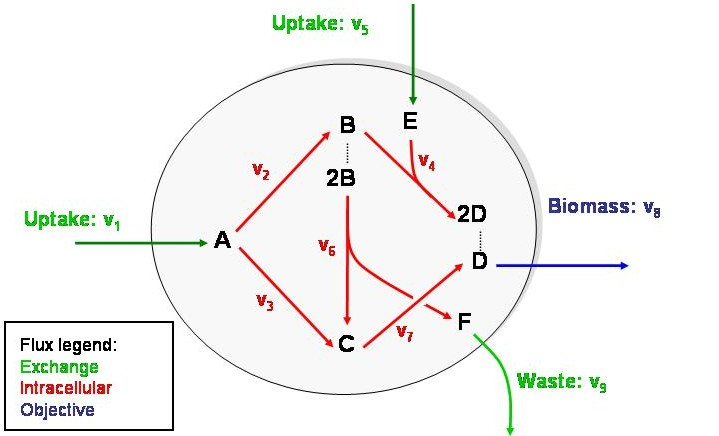

In [3]:
from IPython.display import Image
Image('Metabolic-network.jpeg')


In [4]:
from cobra.util.array import create_stoichiometric_matrix, constraint_matrices
import sys
sys.path.append('../..')
from tests.test_crop import load_model
model = load_model()
stoich_matrix = create_stoichiometric_matrix(model, 'DataFrame')
stoich_matrix

,EX_A_e,EX_C_e,EX_D_e,EX_E_e,EX_F_e,EX_A,EX_C,EX_D,EX_E,SINK_F,R_A_to_B,R_BE_to_D,R_A_to_C,R_BC_to_F,R_C_to_D
A_c,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,-1.0,0.0,0.0
B_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-1.0,0.0,-2.0,0.0
C_c,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-1.0
D_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0
E_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0
F_c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,1.0,0.0
A_e,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C_e,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
D_e,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
E_e,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
constraint_mat = constraint_matrices(model, array_type='DataFrame')
constraint_mat

Problem(equalities=     0    1    2    3    4    5    6    7    8    9   ...   20   21   22   23  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -1.0  1.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0 -1.0 -1.0  1.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  2.0 -2.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0 -1.0  1.0   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6  -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 -1.0  1.0  ...  0.0  0.0  0.0  0.0   

     24 

In [98]:
constraint_mat

Problem(equalities=       0     1      2     3      4     5      6     7      8     9   ...  \
0   0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
1   0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
2   0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
3   0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
4   0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
5   0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
6  -1.000 1.000  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
7   0.000 0.000 -1.000 1.000  0.000 0.000  0.000 0.000  0.000 0.000  ...   
8   0.000 0.000  0.000 0.000 -1.000 1.000  0.000 0.000  0.000 0.000  ...   
9   0.000 0.000  0.000 0.000  0.000 0.000 -1.000 1.000  0.000 0.000  ...   
10  0.000 0.000  0.000 0.000  0.000 0.000  0.000 0.000 -1.000 1.000  ...   

       20     21     22     23     24     25     26     27     28   

In [3]:
# from pprint import pprint
# from cobra.io import write_sbml_model, validate_sbml_model

# write_sbml_model(model, filename='test.xml')
# report = validate_sbml_model(filename='test.xml')
# pprint(report)

In [8]:
import pandas as pd
import numpy as np

# from cvxpy import *
import cvxpy as xpy
from IPython.display import display
pd.options.display.float_format = '{:.0f}'.format

mets = ['A','B','C','D','E','F','A_ext', 'C_ext','D_ext', 'E_ext','F_ext']
internal_mets = [met for met in mets if 'ext' not in met]
rxns = ['R_{}'.format(i) for i in range(1,11)]

data = {'R_1': pd.Series({'A':1, 'A_ext': -1}),
       'R_2': pd.Series({'A':-1,'B':1}),
       'R_3': pd.Series({'A':-1,'C':1}),
       'R_4': pd.Series({'B':-1, 'D': 2, 'E': -1}),
       'R_5': pd.Series({'E':1, 'E_ext':-1}),
       'R_6': pd.Series({'B':-2, 'C':1, 'F': 1}),
       'R_7': pd.Series({'C':-1, 'D':1}),
       'R_8': pd.Series({'D': -1, 'D_ext': 1}),
       'R_9': pd.Series({'F':-1, 'F_ext':1}),
       'R_10': pd.Series({'C':-1, 'C_ext':1})}
fullS = pd.DataFrame(data, columns=rxns, index=mets,dtype='int64').fillna(0)

pd.options.display.float_format = '{:.3f}'.format
# fullS

In [9]:
order = ['EX_A',  'R_A_to_B', 'R_A_to_C', 'R_BE_to_D', 'EX_E', 'R_BC_to_F','R_C_to_D', 'EX_D',  'SINK_F',  'EX_C',]
stoich_matrix = stoich_matrix[order]
# stoich_matrix

In [10]:
(stoich_matrix.values == fullS.values).all()

True

In [11]:
model.medium

{'EX_A_e': 1000.0,
 'EX_C_e': 1000.0,
 'EX_D_e': 1000.0,
 'EX_E_e': 1000.0,
 'EX_F_e': 1000.0}

In [12]:
model.optimize()

,fluxes,reduced_costs
EX_A_e,-500.000,-0.000
EX_C_e,0.000,0.000
EX_D_e,1000.000,2.000
EX_E_e,-500.000,-0.000
EX_F_e,0.000,0.000
...,...,...
R_A_to_B,500.000,0.000
R_BE_to_D,500.000,0.000
R_A_to_C,0.000,-0.000
R_BC_to_F,0.000,0.000


In [13]:
model.slim_optimize()

1000.0

In [14]:
media = {

    # 'B': 100,
    'EX_E_e': 100
}
model.medium = media
obj_func = model.slim_optimize()
print(obj_func)

0.0


### Robustness ###

`CROP` was designed to be robust to unbalanced reactions, because we had unbalanced reactions in our database of metabolic reactions. These unbalanced reactions arose because of difficulties in exporting the MetaCyc reaction to text files, or because a reaction was unbalanced in MetaCyc. Other metabolic reaction databases, such as the Model SEED’s biochemistry database and KEGG, also have unbalanced reactions.
Although the existence of such unbalanced reactions is known [13](https://www.ncbi.nlm.nih.gov/pubmed/18697772), we are not aware of any reconstruction algorithm that accounts for them when trying to suppress *in silico* growth. It was not feasible to manually balance all of the unbalanced reactions in our database. Instead, we had to select which of these reactions may belong in our final model. 
We could not use previous algorithms to select among these unbalanced reactions. To see this, consider the Generic solution strategy. It assumes that the only upper bounds for FBA are those on limiting nutrients, such as glucose. However, an unbalanced reaction could have the form: water $\rightarrow$ glucose, and therefore act like the limiting nutrient. Because this unbalanced reaction wouldn’t have an upper bound according to the Generic solution strategy, its FBA would be unbounded. (Furthermore, we could not treat these reactions like nutrient sources, because doing so implies that we wouldn’t have any decision variable associated with these reactions, so wouldn’t be able to select which belonged in the final model.)
For `CROP` to be robust to unbalanced reactions, we developed a new version of FBA. This version of FBA is called Digital Unlimited-Nutrient Growth FBA (`dung-FBA`). `dung-FBA` is never unbounded, no matter how many unbalanced reactions there are, because it imposes an upper bound on growth: $v_{biomass}\leq 1$. In fact, this is `dung-FBA`’s only upper bound. `dung-FBA` allows unlimited uptake of the available nutrients, so that the only factor limiting growth is connectivity. This feature is similar to `OnePrune`. Moreover, this allows `dung-FBA` to yield a binary (digital) result to the question: is growth possible? Mathematically, `dung-FBA` is defined by the following linear program:  

$$\begin{array}{lll}
\max_v & c^Tv = v_{biomass} \\
\text{subject to} & Sv= 0 &\text{(dung-FBA)} \\
&0\leq v \\
& v_{biomass} \leq 1 \end{array}$$

#### LP dung-FBA implementation ####

In [15]:
S = fullS.loc[internal_mets].values

biomass= 7

nmets, nrxns = S.shape
v = xpy.Variable(nrxns)


dung_fba_lp = xpy.Problem(
    xpy.Maximize( v[biomass] ),
        [    S@v  == 0,
             0 <= v,
            v[biomass]  <= 1])
dung_fba_lp.solve()
display(pd.DataFrame( v.value, index=rxns, columns=['v']))

,v
R_1,1.446
R_2,0.962
R_3,0.484
R_4,0.310
R_5,0.310
R_6,0.326
R_7,0.380
R_8,1.000
R_9,0.326
R_10,0.430


In [16]:
for i in model.constraints:
    print(i)

A_c: 0 <= 1.0*EX_A - 1.0*EX_A_reverse_b86fb - 1.0*R_A_to_B + 1.0*R_A_to_B_reverse_ba61c - 1.0*R_A_to_C + 1.0*R_A_to_C_reverse_e69ab <= 0
B_c: 0 <= 1.0*R_A_to_B - 1.0*R_A_to_B_reverse_ba61c - 2.0*R_BC_to_F + 2.0*R_BC_to_F_reverse_5a162 - 1.0*R_BE_to_D + 1.0*R_BE_to_D_reverse_5fdeb <= 0
C_c: 0 <= -1.0*EX_C + 1.0*EX_C_reverse_69b38 + 1.0*R_A_to_C - 1.0*R_A_to_C_reverse_e69ab + 1.0*R_BC_to_F - 1.0*R_BC_to_F_reverse_5a162 - 1.0*R_C_to_D + 1.0*R_C_to_D_reverse_a7ec1 <= 0
D_c: 0 <= -1.0*EX_D + 1.0*EX_D_reverse_26b84 + 2.0*R_BE_to_D - 2.0*R_BE_to_D_reverse_5fdeb + 1.0*R_C_to_D - 1.0*R_C_to_D_reverse_a7ec1 <= 0
E_c: 0 <= 1.0*EX_E - 1.0*EX_E_reverse_0da8c - 1.0*R_BE_to_D + 1.0*R_BE_to_D_reverse_5fdeb <= 0
F_c: 0 <= 1.0*R_BC_to_F - 1.0*R_BC_to_F_reverse_5a162 - 1.0*SINK_F + 1.0*SINK_F_reverse_e7acf <= 0
A_e: 0 <= -1.0*EX_A - 1.0*EX_A_e + 1.0*EX_A_e_reverse_32c36 + 1.0*EX_A_reverse_b86fb <= 0
C_e: 0 <= 1.0*EX_C - 1.0*EX_C_e + 1.0*EX_C_e_reverse_caf3b - 1.0*EX_C_reverse_69b38 <= 0
D_e: 0 <= 1.0*EX_

In [13]:
from optlang.symbolics import Zero
import optlang.gurobi_interface as optlang
S = fullS.loc[internal_mets].values

nmets, nrxns = S.shape
biomass = 7


variables = []
for i in range(nrxns):
    variables.append(optlang.Variable(f'v_{i}', type='continuous'))
constraints = []

for i in variables:
    cons = optlang.Constraint(i, lb=0)
    constraints.append(cons)


c1 = optlang.Constraint(
    variables[biomass],
    ub=1,
    name='c1',
    sloppy=True,
)
constraints.append(c1)

dung_fba_lp = optlang.Model(
    objective = optlang.Objective(variables[biomass], direction="max"),
    constraints = constraints
    #[ S*v  == 0, 0 <= v, v[biomass]  <= 1],

)
dung_fba_lp.optimize()

ModuleNotFoundError: No module named 'gurobipy'

In [ ]:
for v in variables:
    print(dir(v))

In [ ]:
#v.as_real_imag()
# display(pd.DataFrame( v.value, index=rxns, columns=['v']))

For CROP's MILP, CROP requires the dual of `dung-FBA`. This dual is:

$$\begin{array}{lll}
\min_{m,r} & r_{biomass} \\
\text{subject to} & S^Tm + c = r & \text{(dual of dung-FBA)} \\
& r_{biomass} \geq 0 \\
& r_i\leq 0 & \text{for $i\neq$ biomass} \end{array}$$

####  Dual of LP dung-FBA Implementation ####

In [17]:
r = xpy.Variable(nrxns)
m = xpy.Variable(nmets)
c = np.zeros(nrxns)
c[biomass] = 1
dung_fba_dual_lp = xpy.Problem(
    xpy.Minimize( r[biomass] ),
        [   S.T@m + c      == r,
            r[:biomass]   <=  0,
            r[biomass]    >=  0,
            r[biomass+1:] <=  0])
dung_fba_dual_lp.solve(solver=xpy.SCIPY,)
display(pd.DataFrame( r.value, index=rxns, columns=['r']))
display(pd.DataFrame(m.value, index=internal_mets,columns=['m']))

,r
R_1,-0.000
R_2,-0.000
R_3,-0.000
R_4,-0.000
R_5,-0.000
R_6,-0.000
R_7,-0.000
R_8,1.000
R_9,-0.000
R_10,-0.000


,m
A,-0.000
B,-0.000
C,-0.000
D,-0.000
E,-0.000
F,-0.000


where $r$ is the dual variable associated with reaction constraints, and $m$ is the dual variable associated with metabolite constraints.  Now we add binary decision variables, $z$, so that we can select reactions to remove. `dung-FBA` now becomes

$$\begin{array}{lll}
\max_{v} & c^Tv = v_{biomass} \\
& Sv = 0 \\
& 0\leq v_i \leq U_i z_i & \text{for all $i$}
\end{array}$$

where $U_{biomass}=1$.

#### MILP dung-FBA Implementation ####

In [18]:
S = fullS.loc[internal_mets].values

nmets, nrxns = S.shape

v = xpy.Variable(nrxns)
z = xpy.Variable(nrxns, boolean=True)

biomass= 7

U = np.eye(nrxns)*1000
U[biomass,biomass] = 1

dung_fba_milp = xpy.Problem(
    xpy.Maximize( v[biomass] ),
        [    S@v  == 0,
             0    <= v,
             v    <= U@z])
dung_fba_milp.solve(solver=xpy.SCIPY,)
reactions = pd.DataFrame( np.squeeze(np.asarray(v.value)), index=rxns, columns=['v'])
reactions['z'] = pd.Series(np.squeeze(np.asarray(z.value)), index=rxns)
display(reactions)

,v,z
R_1,0.500,1.000
R_2,0.500,1.000
R_3,-0.000,1.000
R_4,0.500,1.000
R_5,0.500,1.000
R_6,-0.000,1.000
R_7,-0.000,1.000
R_8,1.000,1.000
R_9,0.000,1.000
R_10,-0.000,1.000


The dual of this program is:
$$\begin{array}{lll}
\min_{m,r} & r_{biomass} \\
\text{subject to} & S^Tm + c = r \\
& r_{biomass} \geq 0 \\
& r_i\leq \Omega_i\cdot(1-z_i) & \text{for $i\neq$ biomass} \end{array}$$

For reactions $i$ that are knocked out as a result of a gene knockout, $z_i$ is treated as 0, implying that $r_i\leq\Omega_i$. Since $\Omega_i$ is supposed to be a loose upper bound, we represented this as $r_i$ being free.

We used `dung-FBA` along with `limed-FBA` by replacing the $S$ in `dung-FBA` with `limed-FBA`'s $S_{limed}$.  Using dung-FBA successfully brought us robustness to unbalanced reactions.

#### Dual of MILP dung-FBA  Implementation ####

In [19]:
Omega = 1000

m = xpy.Variable(nmets)
r = xpy.Variable(nrxns)
z = xpy.Variable(nrxns, boolean=True)

dung_fba_dual_milp = xpy.Problem(
    xpy.Minimize( r[biomass] ),
        [    S.T@m + c   == r,
            r[:biomass]   <= Omega*np.eye(biomass)@(1-z[:biomass]),
            r[biomass]    >= 0,
            r[biomass+1:] <= Omega*np.eye(nrxns - biomass - 1)@(1-z[biomass+1:])])
dung_fba_dual_milp.solve(solver=xpy.SCIPY, )


reactions = pd.DataFrame( z.value, index=rxns, columns=['z'])
reactions['r'] = pd.Series(np.squeeze(np.asarray(r.value)), index=rxns)
display(reactions)
metabolites = pd.DataFrame(np.squeeze(np.asarray(m.value)),index=internal_mets, columns=['m'])
display(metabolites)

,z,r
R_1,0.000,1000.000
R_2,0.000,1000.000
R_3,0.000,1000.000
R_4,0.000,-2998.000
R_5,0.000,1000.000
R_6,0.000,-3000.000
R_7,0.000,-1999.000
R_8,0.000,0.000
R_9,0.000,1000.000
R_10,0.000,-2000.000


,m
A,1000.000
B,2000.000
C,2000.000
D,1.000
E,1000.000
F,-1000.000


### Size ###

FBA maximizes growth, so its dual represents an upper bound on growth. Thus, to mathematically express the experimental observation of no-growth (or of growth below a threshold), we need the dual. However, it also follows that once we have the dual, we no longer need FBA. In fact, incorporating both FBA and its dual only provides value if we want to model an intermediate level of growth. This observation appears to have been overlooked. However, only using the dual substantially reduces the MILP’s size.
This observation is actually suggested by program  (17) in *Generic solution strategy*. Program  (17) includes the constraints $v_{biomass}=10r_{glucose}$ and it includes $v_{biomass}\leq$ `minimal_growth`. Together, these constraints imply that $10r_{glucose}\leq$ `minimal_growth`, and that we can ignore $v_{biomass}$. When we remove FBA’s growth maximization from the inner problem of program (17), we get:

$$\begin{array}{ll}
\min_z &  weights^T(1-z) \\
 &\begin{array}{lll}
& S^Tm -r = -c \\
& r_i\leq\Omega_i\cdot(1-z_i) & \text{for $i\neq$ glucose} \\
& r_{glucose} \geq 0 \end{array} \\
& 10r_{glucose} \leq \text{minimal growth} \\
& Sw = 0 \\
& 0\leq w_i \leq U_{wt,i}\cdot z_i \\
& w_{biomass} \geq \text{minimal growth} \\
& w_{ATP} \geq \text{atp maintenance} \\
& z\in \{0,1\}
\end{array}$$

#### Reduced bi-level MILP dung-FBA implementation ####

In [20]:
glucose = 4
ATP = 8
minimal_growth = 0.1
atp_maintenance = 0.1

U       = np.eye(nrxns)*1000.0
weights = np.ones(nrxns)*0.5
Omega   = 1000.0


w = xpy.Variable(nrxns)
m = xpy.Variable(nmets)
r = xpy.Variable(nrxns)
z = xpy.Variable(nrxns, boolean=True)

dung_fba_reduced = xpy.Problem(
    xpy.Minimize( weights.T@(1-z) ),
        [       S.T@m - r        == -c,
                r[:glucose]   <= Omega*np.eye(glucose)@(1 - z[:glucose]),
                r[glucose]      >= 0,
                r[glucose+1:]   <= Omega*np.eye(nrxns - glucose - 1)@(1 - z[glucose+1:]),
                10*r[glucose]   <= minimal_growth,
            S@w             == 0,
            0               <= w,
            w               <= U@z,
            w[biomass]      >= minimal_growth,
            w[ATP]          >= atp_maintenance])
dung_fba_reduced.solve(solver=xpy.SCIPY, )
reactions = pd.DataFrame( z.value, index=rxns, columns=['z'])
reactions['r'] = pd.Series(np.squeeze(np.asarray(r.value)),index=rxns)
reactions['w'] = pd.Series(np.squeeze(np.asarray(r.value)),index=rxns)
display(reactions)
metabolites = pd.DataFrame(m.value,index=internal_mets, columns=['m'])
display(metabolites)

,z,r,w
R_1,NaN,None,None
R_2,NaN,None,None
R_3,NaN,None,None
R_4,NaN,None,None
R_5,NaN,None,None
R_6,NaN,None,None
R_7,NaN,None,None
R_8,NaN,None,None
R_9,NaN,None,None
R_10,NaN,None,None


,m
A,NaN
B,NaN
C,NaN
D,NaN
E,NaN
F,NaN


One issue with the Generic solution strategy is that when there are no solutions that reduce growth to `minimal_growth`, solutions that partially reduce growth are not reported. To overcome this issue, $r_{glucose}$ can be moved to the objective.

$$\begin{array}{ll}
\min_z &  weights^T(1 - z)  + B\cdot r_{glucose}\\
 &\begin{array}{lll}
& S^Tm -r = -c \\
& r_i\leq\Omega_i\cdot(1-z_i) & \text{for $i\neq$ glucose} \\
& r_{glucose} \geq 0 \end{array} \\
& Sw = 0 \\
& 0\leq w_i \leq U_{wt,i}\cdot z_i \\
& w_{biomass} \geq \text{minimal growth} \\
& w_{ATP} \geq \text{atp maintenance} \\
& z\in \{0,1\}
\end{array}$$

where the constant $B$ balances
1. the model's consistency with reaction weights versus
2. consistency with growth phenotypes

#### Partially reduced bi-level MILP dung-FBA implementation ####

In [21]:
glucose = 4
ATP = 8

minimal_growth  = 0.1
atp_maintenance = 0.1

B       = 1000
U       = np.eye(nrxns)*1000.0
weights = np.ones(nrxns)*0.5
Omega   = 1000.0

w = xpy.Variable(nrxns)
m = xpy.Variable(nmets)
r = xpy.Variable(nrxns)
z = xpy.Variable(nrxns, boolean=True)

dung_fba_partially_reduced = xpy.Problem(
    xpy.Minimize( weights.T@(1-z) + B*r[glucose]),
        [       S.T@m - r       == -c,
                r[:glucose]     <= Omega*np.eye(glucose)@(1 - z[:glucose]),
                r[glucose]      >= 0,
                r[glucose+1:]   <= Omega*np.eye(nrxns - glucose - 1)@(1 - z[glucose + 1:]),
            S@w             == 0,
            0               <= w,
            w               <= U@z,
            w[biomass]      >= minimal_growth,
            w[ATP]          >= atp_maintenance])
dung_fba_partially_reduced.solve(solver=xpy.SCIPY, )
reactions = pd.DataFrame( z.value, index=rxns, columns=['z'])
reactions['r'] = pd.Series(np.squeeze(np.asarray(r.value)),index=rxns)
reactions['w'] = pd.Series(np.squeeze(np.asarray(w.value)),index=rxns)
display(reactions)
metabolites = pd.DataFrame(m.value,index=internal_mets, columns=['m'])
display(metabolites)

,z,r,w
R_1,1.000,0.000,0.250
R_2,1.000,0.000,0.250
R_3,1.000,0.000,-0.000
R_4,1.000,0.000,0.050
R_5,1.000,2.000,0.050
R_6,1.000,-0.000,0.100
R_7,0.000,1.000,-0.000
R_8,1.000,0.000,0.100
R_9,1.000,0.000,0.100
R_10,1.000,0.000,0.100


,m
A,0.000
B,0.000
C,-0.000
D,1.000
E,2.000
F,-0.000


Now, we replace the dual of FBA with the dual of `dung-FBA`, which involves substituting $r_{glucose}$ with $r_{biomass}$.

$$\begin{array}{ll}
\min_z &  weights^T(1-z)  + B\cdot r_{biomass}\\
 &\begin{array}{llll}
& S^Tm -r = -c \\
& r_i\leq\Omega_i\cdot(1-z_i) & \text{for $i\neq$ biomass} & \text{(dual of dung-FBA)}\\
& r_{biomass} \geq 0 \end{array} \\
& Sw = 0 \\
& 0\leq w_i \leq U_{wt,i}\cdot z_i & \text{(FBA)} \\
& w_{biomass} \geq \text{minimal growth} \\
& w_{ATP} \geq \text{atp maintenance} \\
& z\in \{0,1\}
\end{array}$$

A numerical difficulty that arises is that although $z_i$ is supposed to be binary, its value may differ from 0 or 1 by a small amount, such as by $10^{-6}$. Thus, even when $z_i$ is supposed to be 1, $r_i$ may not be forced to be negative, but may instead reach $10^{-6}\cdot \Omega_i$. To mitigate the effects of such numerical difficulties, we had some success with using rather small $\Omega_i$ for all reactions, e.g. $\Omega_i=1$. We found that using such tight upper bounds also improved run-time, which is consistent with the findings of others [[14]](https://www.ncbi.nlm.nih.gov/pubmed/20426856).

This section shows that `CROP` deals with conditions where growth is predicted but no growth is experimentally observed with a MILP that is much smaller than previous algorithms, allowing for more efficient solution.

#### Biomass-substituted partially reduced bi-level MILP dung-FBA implementation ####

In [17]:
glucose = 4
ATP = 8
minimal_growth = 0.1
atp_maintenance = 0.1
B = 1000

U       = np.eye(nrxns)*1000.0
weights = np.ones(nrxns)*0.5

w = xpy.Variable(nrxns)
m = xpy.Variable(nmets)
r = xpy.Variable(nrxns)
z = xpy.Variable(nrxns, boolean=True)

for Omega in [1,100,1000,10000]:
    dung_fba_partially_reduced_biomass = xpy.Problem(
        xpy.Minimize( weights.T@(1 - z) + B*r[biomass]),
        [       S.T@m - r       == -c,
                r[:biomass]     <= Omega*np.eye(biomass)@(1 - z[:biomass]),
                r[biomass]      >= 0,
                r[biomass + 1:] <= Omega*np.eye(nrxns - biomass - 1)@(1 - z[biomass + 1:]),
            S@w         == 0,
            0           <= w,
            w           <= U@z,
            w[biomass]  >= minimal_growth,
            w[ATP]      >= atp_maintenance])
    dung_fba_partially_reduced_biomass.solve(solver=xpy.SCIPY, )
    reactions = pd.DataFrame( z.value, index=rxns, columns=['z'])
    reactions['r'] = pd.Series(np.squeeze(np.asarray(r.value)),index=rxns)
    reactions['w'] = pd.Series(np.squeeze(np.asarray(w.value)),index=rxns)
    print('Omega = {}'.format(Omega))
    display(reactions)
    metabolites = pd.DataFrame(m.value,index=internal_mets, columns=['m'])
    display(metabolites)

Omega = 1


,z,r,w
R_1,1.000,0.000,0.200
R_2,1.000,0.000,0.200
R_3,1.000,0.000,-0.000
R_4,1.000,-0.000,-0.000
R_5,1.000,0.000,0.000
R_6,1.000,0.000,0.100
R_7,1.000,-0.000,0.100
R_8,1.000,1.000,0.100
R_9,1.000,0.000,0.100
R_10,1.000,0.000,-0.000


,m
A,0.000
B,0.000
C,0.000
D,0.000
E,-0.000
F,-0.000


Omega = 100


,z,r,w
R_1,1.000,0.000,0.250
R_2,1.000,0.000,0.250
R_3,1.000,0.000,-0.000
R_4,1.000,0.000,0.050
R_5,1.000,0.000,0.050
R_6,1.000,0.000,0.100
R_7,1.000,0.000,-0.000
R_8,1.000,1.000,0.100
R_9,1.000,0.000,0.100
R_10,1.000,0.000,0.100


,m
A,0.000
B,0.000
C,0.000
D,0.000
E,0.000
F,-0.000


Omega = 1000


,z,r,w
R_1,1.000,0.000,0.250
R_2,1.000,0.000,0.250
R_3,1.000,0.000,-0.000
R_4,1.000,0.000,0.050
R_5,1.000,0.000,0.050
R_6,1.000,0.000,0.100
R_7,1.000,0.000,-0.000
R_8,1.000,1.000,0.100
R_9,1.000,0.000,0.100
R_10,1.000,0.000,0.100


,m
A,0.000
B,0.000
C,0.000
D,0.000
E,0.000
F,-0.000


Omega = 10000


,z,r,w
R_1,1.000,0.000,0.250
R_2,1.000,0.000,0.250
R_3,1.000,0.000,-0.000
R_4,1.000,0.000,0.050
R_5,1.000,0.000,0.050
R_6,1.000,0.000,0.100
R_7,1.000,0.000,-0.000
R_8,1.000,1.000,0.100
R_9,1.000,0.000,0.100
R_10,1.000,0.000,0.100


,m
A,0.000
B,0.000
C,0.000
D,0.000
E,0.000
F,-0.000


### Handling multiple conditions simultaneously ###

Facilitated by its robustness and smaller size, `CROP` can simultaneously handle multiple conditions where no growth is experimentally observed. For two conditions where no-growth is experimentally observed, the MILP is similar to above, albeit with an additional dual.

$$\begin{array}{ll}
\min_z &  weights^T(1-z)  + B\cdot( r_{1,biomass} + r_{2,biomass})\\
 &\begin{array}{lll}
& S^Tm_1 -r_1 = -c \\
& r_{1,biomass} \geq 0 &  \text{(dual 1)}\\
& r_{1,i}\leq\Omega_{1,i}\cdot(1-z_i) & \text{for $i\neq$ biomass} 
\end{array} \\
& \\
 &\begin{array}{lll}
& S^Tm_2 -r_2 = -c \\
& r_{2,biomass} \geq 0 &  \text{(dual 2)}\\
& r_{2,i}\leq\Omega_{2,i}\cdot(1-z_i) & \text{for $i\neq$ biomass} 
\end{array} \\
& Sw = 0  \\
& 0\leq w_i \leq U_{wt,i}\cdot z_i & \text{(FBA)} \\
& w_{biomass} \geq \text{minimal growth} \\
& w_{ATP} \geq \text{atp maintenance} \\
& z\in \{0,1\}
\end{array}$$

Handling multiple conditions simultaneously allows for identification of model modifications that synergistically solve these conditions.

#### Multiple condition biomass-substituted partially reduced bi-level MILP dung-FBA Implementation ####

In [11]:
glucose = 0
ATP = 8
minimal_growth = 0.1
atp_maintenance = 0.1
B = 10

U       = np.eye(nrxns)*1000.0
weights = np.ones(nrxns)*0.5

Omega_before = np.eye(biomass)

Omega_after = np.eye(nrxns - biomass - 1)

w = xpy.Variable(nrxns)
m1 = xpy.Variable(nmets)
m2 = xpy.Variable(nmets)

r1 = xpy.Variable(nrxns)
r2 = xpy.Variable(nrxns)
z = xpy.Variable(nrxns, boolean=True)

dung_fba_multiple_conditions = xpy.Problem(
    xpy.Minimize( weights.T@(1-z) + B*(r1[biomass] + r2[biomass])),
    constraints=
        [
            S.T@m1 - r1       == -c,
            r1[:biomass]      == Omega_before@(1 - z[:biomass]),
            r1[biomass]     >= 0,
            r1[biomass+1:]  >= Omega_after@(1-z[biomass+1:]),
                
            S.T@m2 - r2       == -c,
            r2[:biomass]      == np.eye(biomass)@(1 - z[:biomass]),
            r2[biomass]       >= 0,
            r2[biomass+1:]    >= Omega_after@(1-z[biomass+1:]),
            
            S@w             == 0,
            0               <= w,
            w               <= U@z,
            w[biomass]      >= minimal_growth,
            w[ATP]          >= atp_maintenance
        ]
)

dung_fba_multiple_conditions.solve(solver=xpy.SCIPY, )
reactions = pd.DataFrame( z.value, index=rxns, columns=['z'])
reactions['r1'] = pd.Series(np.squeeze(np.asarray(r1.value)), index=rxns)
reactions['r2'] = pd.Series(np.squeeze(np.asarray(r2.value)), index=rxns)
reactions['w'] = pd.Series(np.squeeze(np.asarray(w.value)), index=rxns)
display(reactions)
metabolites = pd.DataFrame(np.squeeze(np.asarray(m1.value)), index=internal_mets, columns=['m1'])
metabolites['m2'] = pd.Series(np.squeeze(np.asarray(m2.value)), index=internal_mets)
display(metabolites)                

,z,r1,r2,w
R_1,1.000,0.000,0.000,0.200
R_2,1.000,0.000,0.000,0.200
R_3,1.000,0.000,0.000,-0.000
R_4,1.000,0.000,0.000,-0.000
R_5,1.000,0.000,0.000,0.000
R_6,1.000,0.000,0.000,0.100
R_7,1.000,0.000,0.000,0.100
R_8,1.000,1.000,1.000,0.100
R_9,1.000,0.000,0.000,0.100
R_10,1.000,0.000,0.000,-0.000


,m1,m2
A,0.000,0.000
B,0.000,-0.000
C,0.000,0.000
D,0.000,0.000
E,0.000,0.000
F,0.000,-0.000


#### Multiple condition nutrient-limited partially reduced bi-level MILP FBA Implementation ####

In [76]:
np.eye(5)

array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]])

In [22]:
nutrient1 = 1
nutrient2 = 4
biomass= 7
ATP = 8
minimal_growth = 0.1
atp_maintenance = 0.1
B = 10

U       = np.eye(nrxns)*1000.0
weights = np.ones(nrxns)*0.5
Omega1 = 1000 
Omega2 = 1000

w = xpy.Variable(nrxns)
m1 = xpy.Variable(nmets)
m2 = xpy.Variable(nmets)

r1 = xpy.Variable(nrxns)
r2 = xpy.Variable(nrxns)
z = xpy.Variable(nrxns, boolean=True)

fba_multiple_conditions = xpy.Problem(
   xpy.Minimize( weights.T@(1-z) + B*(r1[nutrient1] + r2[nutrient2])),
        [       S.T@m1 - r1         == -c,
                r1[:nutrient1]      <= Omega1*np.eye(nutrient1)@(1 - z[:nutrient1]),
                r1[nutrient1]       >= 0,
                r1[nutrient1 + 1:]  <= Omega1*np.eye(nrxns - nutrient1 - 1)@(1 - z[nutrient1 + 1:]),
                
                S.T@m2 - r2         == -c,
                r2[:nutrient2]      <= Omega2*np.eye(nutrient2)@(1 - z[:nutrient2]),
                r2[nutrient2]       >= 0,
                r2[nutrient2 + 1:]  <= Omega2*np.eye(nrxns - nutrient2 - 1)@(1 - z[nutrient2 + 1:]),
            S@w             == 0,
            0               <= w,
            w               <= U@z,
            w[biomass]      >= minimal_growth,
            w[ATP]          >= atp_maintenance])
fba_multiple_conditions.solve(solver=xpy.SCIPY, )
reactions = pd.DataFrame( z.value, index=rxns, columns=['z'])
reactions['r1'] = pd.Series(np.squeeze(np.asarray(r1.value)),index=rxns)
reactions['r2'] = pd.Series(np.squeeze(np.asarray(r2.value)),index=rxns)
reactions['w'] = pd.Series(np.squeeze(np.asarray(w.value)),index=rxns)
display(reactions)
metabolites = pd.DataFrame(np.squeeze(np.asarray(m1.value)), index=internal_mets, columns=['m1'])
metabolites['m2'] = pd.Series(np.squeeze(np.asarray(m2.value)), index=internal_mets)
display(metabolites)

,z,r1,r2,w
R_1,1.000,0.000,0.000,0.250
R_2,1.000,2.000,0.000,0.250
R_3,1.000,0.000,0.000,-0.000
R_4,1.000,0.000,0.000,0.050
R_5,1.000,0.000,2.000,0.050
R_6,1.000,-4.000,0.000,0.100
R_7,0.000,1.000,1.000,-0.000
R_8,1.000,0.000,0.000,0.100
R_9,1.000,0.000,0.000,0.100
R_10,1.000,0.000,0.000,0.100


,m1,m2
A,0.000,0.000
B,2.000,0.000
C,0.000,0.000
D,1.000,1.000
E,0.000,2.000
F,-0.000,-0.000


In [74]:
"""Provide the base class and utility function for gap filling."""


import logging
from typing import TYPE_CHECKING, Dict, List, Optional

from optlang.interface import OPTIMAL
from optlang.symbolics import Zero

from cobra.core import Model
from cobra.util import fix_objective_as_constraint, interface_to_str


if TYPE_CHECKING:
    from cobra import Reaction


logger = logging.getLogger(__name__)


class GapFiller:
    r"""
    The base class for performing gap filling.

    This class implements gap filling based on a mixed-integer approach,
    very similar to that described in [1]_ and the 'no-growth but growth'
    part of [2]_ but with minor adjustments. In short, we add indicator
    variables for using the reactions in the universal model, z_i and then
    solve problem

    minimize: \sum_i c_i * z_i
    s.t.    : Sv = 0
              v_o \ge t
              lb_i \le v_i \le ub_i
              v_i = 0 if z_i = 0

    where lb, ub are respectively the upper, lower flux bounds for reaction i,
    c_i is a cost parameter and the objective v_o is greater than the lower
    bound t. The default costs are 1 for reactions from the universal model,
    100 for exchange (uptake) reactions added and 1 for added demand reactions.

    Note that this is a mixed-integer linear program and as such will be
    expensive to solve for large models. Consider using alternatives [3]_
    such as CORDA instead [4,5]_ .

    Parameters
    ----------
    model : cobra.Model
        The model to perform gap filling on.
    universal : cobra.Model, optional
        A universal model with reactions that can be used to complete the
        `model` (default None).
    lower_bound : float, optional
        The minimally accepted flux for the objective in the filled model
        (default 0.05).
    penalties : dict, optional
        A dictionary with keys being 'universal' (all reactions included in
        the universal model), 'exchange' and 'demand' (all additionally
        added exchange and demand reactions) for the three reaction types.
        Can also have reaction identifiers for reaction specific costs.
        Defaults are 1, 100 and 1 respectively (default None).
    exchange_reactions : bool, optional
        Consider adding exchange (uptake) reactions for all metabolites
        in the model (default False).
    demand_reactions : bool, optional
        Consider adding demand reactions for all metabolites (default True).
    integer_threshold : float, optional
        The threshold at which a value is considered non-zero (aka
        integrality threshold). If gapfilled models fail to validate,
        you may want to lower this value (default 1E-6).

    Attributes
    ----------
    indicators: list of optlang.interface.Variable
        The list of symbolic indicator variables.
    costs: dict of {optlang.interface.Variable: float}
        The dictionary with symbolic variables as keys and their cost as
        values.

    References
    ----------
    .. [1] Reed, Jennifer L., Trina R. Patel, Keri H. Chen, Andrew R. Joyce,
       Margaret K. Applebee, Christopher D. Herring, Olivia T. Bui, Eric M.
       Knight, Stephen S. Fong, and Bernhard O. Palsson. “Systems Approach
       to Refining Genome Annotation.” Proceedings of the National Academy
       of Sciences 103, no. 46 (2006): 17480–17484.

    .. [2] Kumar, Vinay Satish, and Costas D. Maranas. “GrowMatch: An
       Automated Method for Reconciling In Silico/In Vivo Growth
       Predictions.” Edited by Christos A. Ouzounis. PLoS Computational
       Biology 5, no. 3 (March 13, 2009): e1000308.
       doi:10.1371/journal.pcbi.1000308.

    .. [3] http://opencobra.github.io/cobrapy/tags/gapfilling/

    .. [4] Schultz, André, and Amina A. Qutub. “Reconstruction of
       Tissue-Specific Metabolic Networks Using CORDA.” Edited by Costas D.
       Maranas. PLOS Computational Biology 12, no. 3 (March 4, 2016):
       e1004808. doi:10.1371/journal.pcbi.1004808.

    .. [5] Diener, Christian https://github.com/cdiener/corda

    """

    def __init__(
        self,
        model: Model,
        universal: Optional[Model] = None,
        lower_bound: float = 0.05,
        penalties: Optional[Dict[str, "Reaction"]] = None,
        exchange_reactions: bool = False,
        demand_reactions: bool = True,
        integer_threshold: float = 1e-6,
        **kwargs,
    ) -> None:
        """Initialize a new GapFiller object.

        Other Parameters
        ----------------
        kwargs :
            Further keyword arguments are passed on to the parent class.

        """
        self.original_model = model
        self.lower_bound = lower_bound
        self.model = model.copy()
        tolerances = self.model.solver.configuration.tolerances
        try:
            tolerances.integrality = integer_threshold
        except AttributeError:
            logger.warning(
                f"The current solver interface {interface_to_str(self.model.problem)} "
                f"doesn't support setting the integrality tolerance."
            )
        # TODO (Midnighter): One could debate how useful it is to compare against this
        #  threshold when it is not supported by the chosen solver.
        self.integer_threshold = integer_threshold
        self.universal = universal.copy() if universal else Model("universal")
        self.penalties = dict(universal=1, exchange=100, demand=1)
        if penalties is not None:
            self.penalties.update(penalties)
        self.indicators = []
        self.costs = {}
        self.extend_model(exchange_reactions, demand_reactions)
        fix_objective_as_constraint(self.model, bound=lower_bound)
        self.add_switches_and_objective()

    def extend_model(
        self, exchange_reactions: bool = False, demand_reactions: bool = True
    ) -> None:
        """Extend gap filling model.

        Add reactions from universal model and optionally exchange and
        demand reactions for all metabolites in the model to perform
        gap filling on.

        Parameters
        ----------
        exchange_reactions : bool, optional
            Consider adding exchange (uptake) reactions for all metabolites
            in the model (default False).
        demand_reactions : bool, optional
            Consider adding demand reactions for all metabolites
            (default True).

        """
        for rxn in self.universal.reactions:
            rxn.gapfilling_type = "universal"
        new_metabolites = self.universal.metabolites.query(
            lambda metabolite: metabolite not in self.model.metabolites
        )
        self.model.add_metabolites(new_metabolites)
        existing_exchanges = []
        for rxn in self.universal.boundary:
            existing_exchanges = existing_exchanges + [
                met.id for met in list(rxn.metabolites)
            ]

        for met in self.model.metabolites:
            if exchange_reactions:
                # check for exchange reaction in model already
                if met.id not in existing_exchanges:
                    rxn = self.universal.add_boundary(
                        met,
                        type="exchange_smiley",
                        lb=-1000,
                        ub=0,
                        reaction_id=f"EX_{met.id}",
                    )
                    rxn.gapfilling_type = "exchange"
            if demand_reactions:
                rxn = self.universal.add_boundary(
                    met,
                    type="demand_smiley",
                    lb=0,
                    ub=1000,
                    reaction_id=f"DM_{met.id}",
                )
                rxn.gapfilling_type = "demand"

        new_reactions = self.universal.reactions.query(
            lambda reaction: reaction not in self.model.reactions
        )
        self.model.add_reactions(new_reactions)

    def update_costs(self) -> None:
        """Update coefficients for the indicator variables in the objective.

        Done incrementally so that second time the function is called,
        active indicators in the current solutions gets higher cost than the
        unused indicators.

        """
        for var in self.indicators:
            if var not in self.costs:
                self.costs[var] = var.cost
            else:
                if var._get_primal() > self.integer_threshold:
                    self.costs[var] += var.cost
        self.model.objective.set_linear_coefficients(self.costs)

    def add_switches_and_objective(self) -> None:
        """Update gap filling model with switches and indicator objective."""
        constraints = []
        big_m = max(max(abs(b) for b in r.bounds) for r in self.model.reactions)
        prob = self.model.problem
        for rxn in self.model.reactions:
            if not hasattr(rxn, "gapfilling_type"):
                continue
            indicator = prob.Variable(
                name=f"indicator_{rxn.id}", lb=0, ub=1, type="binary"
            )
            if rxn.id in self.penalties:
                indicator.cost = self.penalties[rxn.id]
            else:
                indicator.cost = self.penalties[rxn.gapfilling_type]
            indicator.rxn_id = rxn.id
            self.indicators.append(indicator)

            # if z = 1 v_i is allowed non-zero
            # v_i - Mz <= 0   and   v_i + Mz >= 0
            constraint_lb = prob.Constraint(
                rxn.flux_expression - big_m * indicator,
                ub=0,
                name=f"constraint_lb_{rxn.id}",
                sloppy=True,
            )
            constraint_ub = prob.Constraint(
                rxn.flux_expression + big_m * indicator,
                lb=0,
                name=f"constraint_ub_{rxn.id}",
                sloppy=True,
            )

            constraints.extend([constraint_lb, constraint_ub])

        self.model.add_cons_vars(self.indicators)
        self.model.add_cons_vars(constraints, sloppy=True)
        self.model.objective = prob.Objective(Zero, direction="min", sloppy=True)
        self.model.objective.set_linear_coefficients({i: 1 for i in self.indicators})
        self.update_costs()

    def fill(self, iterations: int = 1) -> List[List["Reaction"]]:
        """Perform the gap filling.

        With every iteration, it solves the model, updates the costs and
        records the used reactions.

        Parameters
        ----------
        iterations : int, optional
            The number of rounds of gap filling to perform. For every
            iteration, the penalty for every used reaction increases
            linearly. This way, the algorithm is encouraged to search for
            alternative solutions which may include previously used
            reactions i.e., with enough iterations pathways including 10
            steps will eventually be reported even if the shortest pathway
            is a single reaction (default 1).

        Returns
        -------
        list of list of cobra.Reaction
            A list of lists where each element is a list of reactions that
            were used to gap fill the model.

        Raises
        ------
        RuntimeError
            If the model fails to be validated (i.e. the original model with
            the proposed reactions added, still cannot get the required flux
            through the objective).

        """
        used_reactions = []
        for _ in range(iterations):
            self.model.slim_optimize(
                error_value=None, message="gap filling optimization failed"
            )
            solution = [
                self.model.reactions.get_by_id(ind.rxn_id)
                for ind in self.indicators
                if ind._get_primal() > self.integer_threshold
            ]
            if not self.validate(solution):
                raise RuntimeError(
                    "Failed to validate gap filled model, "
                    "try lowering the integer threshold."
                )
            used_reactions.append(solution)
            self.update_costs()
        return used_reactions

    def validate(self, reactions: List["Reaction"]) -> bool:
        """Validate the model.

        Parameters
        ----------
        reactions: list of cobra.Reaction
            The reactions to add to the model for validation.

        Returns
        -------
        bool
            Whether the model is valid or not.

        """
        with self.original_model as model:
            mets = [x.metabolites for x in reactions]
            all_keys = set().union(*(d.keys() for d in mets))
            model.add_metabolites(all_keys)
            model.add_reactions(reactions)
            model.slim_optimize()
            return (
                model.solver.status == OPTIMAL
                and model.solver.objective.value >= self.lower_bound
            )


,z,r1,r2,w
R_1,1.000,0.000,0.000,1000.000
R_2,1.000,2.000,0.000,1000.000
R_3,1.000,-0.000,0.000,0.000
R_4,1.000,0.000,-0.000,0.050
R_5,1.000,-0.000,2.000,0.050
R_6,1.000,-4.000,0.000,499.975
R_7,0.000,1.000,1.000,0.000
R_8,1.000,0.000,0.000,0.100
R_9,1.000,-0.000,0.000,499.975
R_10,1.000,-0.000,-0.000,499.975


,m1,m2
A,0.000,0.000
B,2.000,0.000
C,0.000,0.000
D,1.000,1.000
E,0.000,2.000
F,0.000,-0.000


# References #
1. Arakaki A, Huang Y, Skolnick J (2009) EFICAz2: enzyme function inference by a combined approach enhanced by machine learning. BMC Bioinformatics 10: 107.
2. Jankowski M, Henry C, Broadbelt L, Hatzimanikatis V (2008) Group Contribution Method for Thermodynamic Analysis of Complex Metabolic Networks. Biophysical Journal 95: 1487-1499.
3. Fleming RM, Thiele I, Nasheuer HP (2009) Quantitative assignment of reaction directionality in constraint-based models of metabolism: Application to Escherichia coli. Biophysical Chemistry 145: 47-56.
4. Bar-Even A, Noor E, Flamholz A, Buescher J, Milo R (2011) Hydrophobicity and charge shape cellular metabolite concentrations. PLoS computational biology 7: e1002166.
5. Henry C, Jankowski M, Broadbelt L, Hatzimanikatis V (2006) Genome-Scale Thermodynamic Analysis of Escherichia coli Metabolism. Biophysical Journal 90: 1453-1461.
6. Kumar V, Maranas C (2009) GrowMatch: An Automated Method for Reconciling In Silico/In Vivo Growth Predictions. PLoS Comput Biol 5: e1000308.
7. Henry C, Zinner J, Cohoon M, Stevens R (2009) iBsu1103: a new genome-scale metabolic model of Bacillus subtilis based on SEED annotations. Genome Biology 10: R69.
8. Henry C, DeJongh M, Best A, Frybarger P, Linsay B, et al. (2010) High-throughput generation, optimization and analysis of genome-scale metabolic models. Nat Biotech 28: 977-982.
9. Mitchell J (2001) Restarting after Branching in the SDP Approach to MAX-CUT and Similar Combinatorial Optimization Problems http://www.nature.com/nbt/journal/v28/n9/full/nbt.1672.html. Journal of Combinatorial Optimization 5: 151-166.
10. Burgard A, Maranas C (2003) [Optimization-based framework for inferring and testing hypothesized metabolic objective functions](https://www.ncbi.nlm.nih.gov/pubmed/12673766). Biotechnology and bioengineering 82: 670-677.
11. Boyd S, Vandenberghe L (2004) Convex Optimization: Cambridge University Press.
12. Zomorrodi A, Maranas C (2010) Improving the iMM904 S. cerevisiae metabolic model using essentiality and synthetic lethality data. BMC Systems Biology 4: 178.
13. Gevorgyan A, Poolman M, Fell D (2008) Detection of stoichiometric inconsistencies in biomolecular models. Bioinformatics 24: 2245-2251.
14. Kim J, Reed J (2010) OptORF: Optimal metabolic and regulatory perturbations for metabolic engineering of microbial strains. BMC Systems Biology 4: 53.
